Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [x] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [58]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [77]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [60]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [83]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
#    X['amount_tsh'] = X.amount_tsh.apply(lambda x: np.log(x+1))
    X['population'] = X.population.apply(lambda x: np.log(x+1))
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
test = wrangle(test)

KeyError: "['quantity_group' 'payment_type'] not found in axis"

In [79]:
target = 'status_group'
features = train.columns.drop('status_group')

In [80]:
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [14]:
%config IPCompleter.greedy=True

In [81]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state = 15)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators' : [110,100,90],
    'randomforestclassifier__min_samples_leaf' : [2,1]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=4, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

C:\Users\jonma\Programming\Anaconda\envs\unit2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  22 out of  48 | elapsed:   50.7s remaining:   60.0s
[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:   57.3s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done  32 out of  48 | elapsed:  1.0min remaining:   30.3s
[Parallel(n_jobs=-1)]: Done  37 out of  48 | elapsed:  1.3min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:  1.3min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.4min finished


Wall time: 1min 36s


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [26]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 42, 'randomforestclassifier__min_samples_leaf': 3}
Cross-validation MAE 0.807895622895623


In [82]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_leaf': 2}
Cross-validation MAE 0.8110942760942761


In [46]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=11, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

Wall time: 2.65 s


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantit...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

In [41]:
%%time
k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', scores)

MAE for 3 folds: [0.80606061 0.80459596 0.80237374]
Wall time: 27.4 s


In [47]:
train_split, val = train_test_split(train)
X_val = val[features]
y_val = val[target]
y_pred = pipeline.predict(X_val)

In [52]:
accuracy_score(y_val, y_pred)

0.9999326599326599

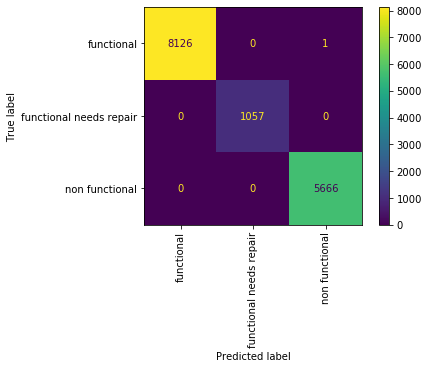

In [49]:
plot_confusion_matrix(pipeline,X_val,y_val, xticks_rotation='vertical', values_format='d')
# Insanely overfit

In [100]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = search.predict(X_test)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('jon_nguyen_8th.csv', index=False)

In [55]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1, min_samples_leaf=5)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

Wall time: 2.45 s


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantit...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

In [97]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state = 22)
)

param_distributions = {
#    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators' : [300,350,320],
    'randomforestclassifier__max_depth' : [15,18,20]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

C:\Users\jonma\Programming\Anaconda\envs\unit2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed:  2.1min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:  2.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed:  2.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:  3.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed:  3.4min remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.5min finished


Wall time: 4min 8s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [98]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'randomforestclassifier__n_estimators': 350, 'randomforestclassifier__max_depth': 20}
Cross-validation MAE 0.8121885521885522


In [99]:
y_pred = search.predict(X_val)
accuracy_score(y_val, y_pred)

0.9425589225589226

In [85]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 90, 'randomforestclassifier__min_samples_leaf': 2}
Cross-validation MAE 0.8126094276094277


In [86]:
y_pred = search.predict(X_val)
accuracy_score(y_val, y_pred)

0.9302356902356902

In [ ]:
SimpleImputer strategy as median, and for RandomForestClassifier, n_estimators = 341, max_depth=20

In [87]:
pipeline1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators = 341, max_depth=20)
)

pipeline1.fit(X_train, y_train)
y_pred = pipeline1.predict(X_val)
accuracy_score(y_val, y_pred)

0.9435016835016835

In [101]:
### STRETCH, rack 'em and stack 'em

# Filenames of your submissions you want to ensemble


files = ['jon_nguyen_ensemble.csv', 'jon_nguyen_6th.csv', 'jon_nguyen_7th.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
 
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('jon_nguyen_ensemble_final.csv', index=False)